# Analysis of the Autogluon results

##### Imports

In [174]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from tabulate import tabulate

In [175]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

##### Create Summaries

In [176]:
df_all = pd.DataFrame(columns=['Dataset', 'Type', 'Method', 'Value'])   
eval_files = os.listdir('evaldict')

for eval_file in eval_files:
    core_name = eval_file[:-len('.parquet')]
    parts = core_name.split('_')
    method = parts[-1]
    parts.remove(method)
    parts.remove(parts[0])
    dataset = '_'.join(parts)
    eval_df = pd.read_parquet('evaldict/' + eval_file)
    
    try:
        rmse = (- eval_df["root_mean_squared_error"]).tolist()
        value = np.average(rmse)
        df_all = df_all._append({'Dataset': dataset, 'Type': 'regression', 'Method': method, 'Value': value}, ignore_index=True)
    except KeyError:
        try:
            roc_auc = (- eval_df["roc_auc"]).tolist()
            value = np.average(roc_auc)
            df_all = df_all._append({'Dataset': dataset, 'Type': 'binary', 'Method': method, 'Value': value},ignore_index=True)
        except KeyError:
            log_loss = (- eval_df["log_loss"]).tolist()
            value = np.average(log_loss)
            df_all = df_all._append({'Dataset': dataset, 'Type': 'multiclass', 'Method': method, 'Value': value},ignore_index=True)
print(df_all)

   Dataset        Type    Method     Value
0  abalone  regression  original  3.574203
1  abalone  regression    openfe  3.160517


##### Add Std Deviation

In [177]:
df_stddev = df_all.groupby(['Dataset', 'Type', 'Method'])['Value'].std().reset_index()
df_stddev.rename(columns={'Value': 'StdDev'}, inplace=True)
df_stddev['StdDev'] = df_stddev['StdDev'].fillna(0)
# Average values
df_summary = df_all.groupby(['Dataset', 'Type', 'Method'])['Value'].mean().reset_index().fillna(0)
print(df_summary)

   Dataset        Type    Method     Value
0  abalone  regression    openfe  3.160517
1  abalone  regression  original  3.574203


In [178]:
df_summary = pd.merge(df_summary, df_stddev)
df_summary['Value_with_StdDev'] = df_summary.apply(lambda row: f"{row['Value']} ± {row['StdDev']}", axis=1)
print(df_summary)

   Dataset        Type    Method     Value  StdDev         Value_with_StdDev
0  abalone  regression    openfe  3.160517     0.0  3.1605172821529592 ± 0.0
1  abalone  regression  original  3.574203     0.0  3.5742031644559726 ± 0.0


In [179]:
# Print and write to file
pivot_table = df_summary.pivot(index=['Dataset', 'Type'], columns=['Method'], values='Value_with_StdDev').fillna('Failed')
pivot_table.reset_index(inplace=True)
pivot_table.to_parquet('tabular_data.parquet')
print(tabulate(pivot_table, headers='keys', tablefmt='pretty'))

+---+---------+------------+--------------------------+--------------------------+
|   | Dataset |    Type    |          openfe          |         original         |
+---+---------+------------+--------------------------+--------------------------+
| 0 | abalone | regression | 3.1605172821529592 ± 0.0 | 3.5742031644559726 ± 0.0 |
+---+---------+------------+--------------------------+--------------------------+


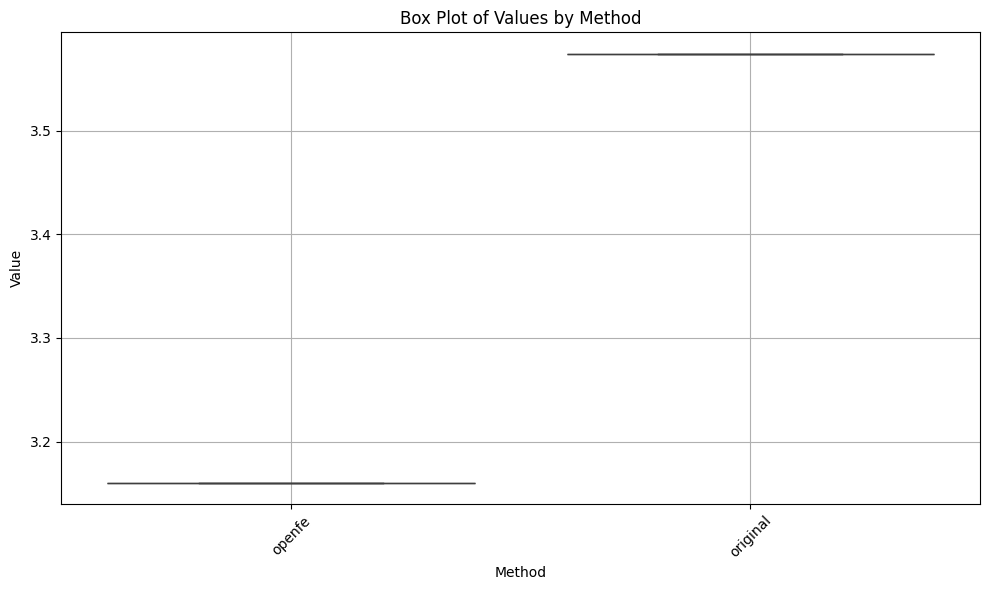

In [180]:
# Extract values
def extract_value(value_with_stddev):
    try:
        value, _ = value_with_stddev.split(' ± ')
        return float(value)
    except:
        return None        

pivot_table_numeric = pivot_table.set_index('Dataset').applymap(extract_value).reset_index()

# Melt DataFrame to format for seaborn
melted_df = pd.melt(pivot_table_numeric, id_vars=['Dataset', 'Type'], var_name='Method', value_name='Value')

plt.figure(figsize=(10, 6))
sns.boxplot(x='Method', y='Value', data=melted_df)
plt.xlabel("Method")
plt.ylabel("Value")
plt.title("Box Plot of Values by Method")
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary
plt.grid(True)
plt.tight_layout()
plt.savefig('plots/box_plot.png')
plt.show()